In [ ]:
!nvidia-smi

In [ ]:
!pip install pypots

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.forecasting.timesnet import TimesNet
from pypots.optim.adam import Adam

# 1. Đọc & resample data (theo phút → theo phút, giữ nguyên)
df = pd.read_csv('/kaggle/input/clean-ts/clean.csv', index_col='dt', parse_dates=True)

feature_cols = [
    'Global_active_power','Global_reactive_power','Voltage','Global_intensity',
    'Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'sin_hour','cos_hour','sin_dow','cos_dow','is_holiday',
    'lag1','lag24','lag168','roll_mean_3h'
]
target_col = 'Global_active_power'

X = df[feature_cols].values
y = df[[target_col]].values

# 3. Scale
train_size = int(len(df)*0.8)
scaler_X = StandardScaler().fit(X[:train_size])
scaler_y = StandardScaler().fit(y[:train_size])

X_train = scaler_X.transform(X[:train_size])
X_val   = scaler_X.transform(X[train_size:])
y_train = scaler_y.transform(y[:train_size])
y_val   = scaler_y.transform(y[train_size:])

# 4. Sliding window với n_steps lớn
def make_windows(X, y, n_steps, n_pred):
    Xs, Ys = [], []
    for i in range(len(X) - n_steps - n_pred + 1):
        Xs.append(X[i:i+n_steps])
        Ys.append(y[i+n_steps:i+n_steps+n_pred])
    return np.stack(Xs).astype(np.float32), np.stack(Ys).astype(np.float32)

n_steps = 14
n_pred  = 1

Xs_train, Xp_train = make_windows(X_train, y_train, n_steps, n_pred)
Xs_val,   Xp_val   = make_windows(X_val,   y_val,   n_steps, n_pred)

2025-06-21 08:49:02.017933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750495742.041070     163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750495742.048133     163 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [2]:
Xs_train.shape

(1660193, 14, 16)

In [3]:
model = TimesNet(
    n_steps=n_steps,
    n_features=Xs_train.shape[-1],
    n_pred_steps=n_pred,
    n_pred_features=1,
    n_layers=3,
    top_k=5,
    d_model=32,
    d_ffn=32,
    n_kernels=6,
    dropout=0.0,
    batch_size=50000,
    epochs=20,
    patience=5,
    optimizer=Adam(lr=1e-3),
    device='cuda:0',
    verbose=True,
    saving_path="/kaggle/working/"
)

train_set = {'X': Xs_train, 'X_pred': Xp_train}
val_set   = {'X': Xs_val,   'X_pred': Xp_val}


2025-06-21 08:49:20 [INFO]: Using the given device: cuda:0
2025-06-21 08:49:20 [INFO]: Model files will be saved to /kaggle/working/20250621_T084920
2025-06-21 08:49:20 [INFO]: Tensorboard file will be saved to /kaggle/working/20250621_T084920/tensorboard
2025-06-21 08:49:20 [INFO]: Using customized MSE as the training loss function.
2025-06-21 08:49:20 [INFO]: Using customized MSE as the validation metric function.
2025-06-21 08:49:20 [INFO]: TimesNet initialized with the given hyperparameters, the number of trainable parameters: 1,760,258


In [4]:
model.fit(train_set, val_set)

2025-06-21 08:58:02 [INFO]: Epoch 001 - training loss (MSE): 0.3032, validation MSE: 0.0928
2025-06-21 09:06:37 [INFO]: Epoch 002 - training loss (MSE): 0.1119, validation MSE: 0.0583
2025-06-21 09:15:12 [INFO]: Epoch 003 - training loss (MSE): 0.0835, validation MSE: 0.0484
2025-06-21 09:23:46 [INFO]: Epoch 004 - training loss (MSE): 0.0710, validation MSE: 0.0432
2025-06-21 09:32:20 [INFO]: Epoch 005 - training loss (MSE): 0.0651, validation MSE: 0.0405
2025-06-21 09:40:54 [INFO]: Epoch 006 - training loss (MSE): 0.0619, validation MSE: 0.0392
2025-06-21 09:49:28 [INFO]: Epoch 007 - training loss (MSE): 0.0595, validation MSE: 0.0382
2025-06-21 09:58:14 [INFO]: Epoch 008 - training loss (MSE): 0.0578, validation MSE: 0.0380
2025-06-21 10:07:02 [INFO]: Epoch 009 - training loss (MSE): 0.0566, validation MSE: 0.0370
2025-06-21 10:15:50 [INFO]: Epoch 010 - training loss (MSE): 0.0557, validation MSE: 0.0369
2025-06-21 10:24:38 [INFO]: Epoch 011 - training loss (MSE): 0.0553, validation 

In [5]:
!mkdir weights

In [6]:
model.save("/kaggle/working/weights")

2025-06-21 11:43:35 [INFO]: Saved the model to /kaggle/working/weights.pypots


In [8]:
print("finish")

finish


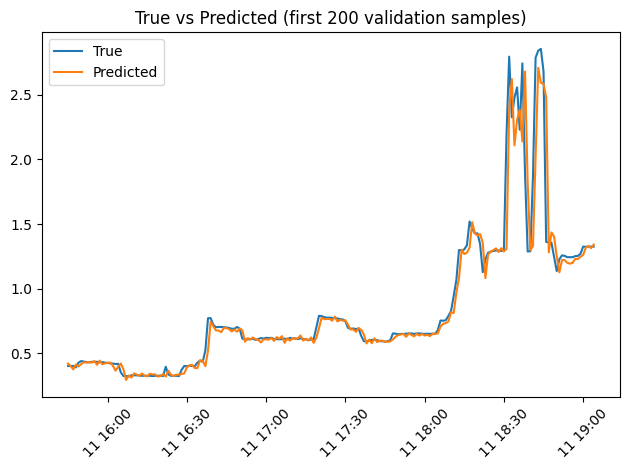

MSE on validation set: 0.0411
MAE on validation set: 0.0817


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# — 1) Dự báo trên tập validation —
# phải truyền dict có key 'X', và forecast() trả về numpy array
# shape: [n_val_samples, n_pred_steps, n_pred_features]
pred_array = model.forecast({'X': Xs_val})  

# — 2) Bỏ các chiều đơn —
# pred_array[...,0,0] => 1D array length n_val
preds_scaled = pred_array.squeeze(axis=2).squeeze(axis=1)   

# — 3) Đảo ngược scaling để về thang gốc —
# scaler_y was fit on shape (n,1)
y_pred = scaler_y.inverse_transform(preds_scaled.reshape(-1,1)).ravel()  

# — 4) Lấy giá trị thực từ Xp_val (ground-truth) —
# Xp_val shape [n_val, n_pred_steps, n_pred_features]
true_scaled = Xp_val.squeeze(axis=2).squeeze(axis=1)
y_true = scaler_y.inverse_transform(true_scaled.reshape(-1,1)).ravel()

# — 5) Lấy index thời gian cho validation —
times = df.index[train_size + n_steps : train_size + n_steps + len(y_true)]

# — 6) Vẽ biểu đồ 200 mẫu đầu —
plt.figure()
plt.plot(times[:200], y_true[:200], label='True')
plt.plot(times[:200], y_pred[:200], label='Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.title('True vs Predicted (first 200 validation samples)')
plt.tight_layout()
plt.savefig('forecast_vs_true_200.png', dpi=300, bbox_inches='tight')
plt.show()

# — 7) Tính MSE & MAE trên toàn bộ tập validation —
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f'MSE on validation set: {mse:.4f}')
print(f'MAE on validation set: {mae:.4f}')



In [14]:
plt.savefig('Timesnet.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [16]:
import pickle

with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)